# Retrieving data from GitHub API v3

In [31]:
import pandas as pd
import requests
import json
import networkx as nx

import os

from modules import config
from modules import plotting

# Extension to auto reload custom modules
%load_ext autoreload

%autoreload 1

%aimport modules.plotting

In [2]:
# Establishing authentication
username = 'danovad'
token = config.GITHUB_TOKEN # Token coming from config.py

Issuing a request to retrieve API rate limit.

In [129]:
r = requests.get("https://api.github.com/rate_limit", auth=(username,token))
r.status_code

json.loads(r.content)

{'resources': {'core': {'limit': 5000,
   'used': 5,
   'remaining': 4995,
   'reset': 1599536422},
  'search': {'limit': 30, 'used': 0, 'remaining': 30, 'reset': 1599532894},
  'graphql': {'limit': 5000,
   'used': 0,
   'remaining': 5000,
   'reset': 1599536434},
  'integration_manifest': {'limit': 5000,
   'used': 0,
   'remaining': 5000,
   'reset': 1599536434},
  'source_import': {'limit': 100,
   'used': 0,
   'remaining': 100,
   'reset': 1599532894},
  'code_scanning_upload': {'limit': 500,
   'used': 0,
   'remaining': 500,
   'reset': 1599536434}},
 'rate': {'limit': 5000, 'used': 5, 'remaining': 4995, 'reset': 1599536422}}

`def github_request_by_url(url):`

In [7]:
def github_request_by_url(url):
    # make the get request
    r = requests.get(url, auth=(username,token))
    
    # unpack and return
    return json.loads(r.content)

Handful of functions to retrieve data

`def github_request(user, endpoint=None)`

In [58]:
def github_request(userlist, endpoint = None):
    ''' Function to retrieve user details.
    If endpoint = None, then it will retrieve user info. 
    If endpoint is set to 
    "following", 
    "followers", 
    "repos", 
    "subscriptions",
    "events", etc it will handle those requests as such. '''
    if endpoint is not None:
        url = f'https://api.github.com/users/{user}/{endpoint}'
        #print(f"Requesting {url}")
    else:
        url = f'https://api.github.com/users/{user}'
        print(f"Requesting {url}")
    
    # make the get request
    r = requests.get(url, auth=(username,token))
    if r.status_code != 200:
        print("Something went wrong.")
    # unpack and return
    return json.loads(r.content)

<pre><code>def generate_user_details_dict(user):
    ''' 
    Function generates a dictionary for a specific user. 
    
    This combines user details and users following.
    '''</code></pre>

In [13]:
def generate_user_details_dict(user):
    ''' Function generates a dictionary for a specific user. 
    
    This combines user details and users following.'''
    
    # First we need to get the users details
    user_details_dict = github_request(user)

    # Add user_following_list login names to user_details_dict as a key:value pair (login:list of logins)
    user_details_dict['following_users'] = [user['login'] for user in github_request(user, endpoint = 'following')]
    user_details_dict['followers_users'] = [user['login'] for user in github_request(user, endpoint = 'followers')]
    
    return user_details_dict

In [127]:
def get_userlist_details(userlist):
    '''
    For a list of users, return a list of dictionaries, 
    with their resulting details.
    '''
    users_details_list = []
    for user in userlist:
        users_details_list.append(generate_user_details_dict(user))
    
    return users_details_list
    

In [132]:
a = get_userlist_details(['danovad','tomerovadia','cooperdramsey'])

In [136]:
[user['following_users'] for user in a]

[['pjreddie',
  'yovadia',
  'josephofiowa',
  'tomerovadia',
  'matthewbrems',
  'cooperdramsey',
  'aailani',
  'Wsauder',
  'sjhawkes',
  'scaress21'],
 ['mbostock',
  'tbeck',
  'ruggeri',
  'emilyschultz',
  'hellochitty',
  'plupinska',
  'carlbaron',
  'composerinteralia',
  'amplesample',
  'tbuchannan',
  'paskhaver',
  'DanOvad',
  'Cirakuze',
  'rsa2135',
  'taekyunggg',
  'ayellapragada',
  'abseee',
  'MichaelMCoates',
  'christinewang319',
  'WilsonMinFong',
  'dallaswmorgan',
  'parkjphilip',
  'pauliewax',
  'RoyceJH',
  'madelineleclair',
  'jon-lin',
  'cmakow',
  'mbryantramirez',
  'vonbarown'],
 ['Sintrastes', 'samestep', 'DanOvad', 'tomerovadia', 'mbr4477']]

In [ ]:
def get_following_userlist(userlist):
    '''Get a unique list of following users from a list of users'''
    
    for user in userlist:
        generate_user_details_dict(user)

In [187]:
def return_following_details_list(user):
    '''
    Function generates a list of dictionaries. 
    '''
    users_details_list = []
    users_login_set = set(user)
    users_details_list.append(generate_user_details_dict(user))
    
    # Loop over all users following and generate their own user details dictionaries.
    for fol_user in users_details_list[0]['following_users']:
        print(fol_user)
        users_login_set.add(fol_user)
        users_details_list.append(generate_user_details_dict(fol_user))    
        
    #new_following_users = set().add([user_details['following_users'] for user_details in users_details_list])
    #unique_new_users = users_login_set.difference(new_following_users)
    
    
    return users_details_list, unique_new_users

In [186]:
users_details_list, unique_new_users = return_following_details_list('danovad')

pjreddie
yovadia
josephofiowa
tomerovadia
matthewbrems
cooperdramsey
aailani
Wsauder
sjhawkes
scaress21


TypeError: unhashable type: 'list'

In [178]:
unique_new_users

{'a', 'd', 'n', 'o', 'v'}

In [80]:
# Generating a dictionary of user to following users for networkX graphs
network_nodes = {user['login']:user['following_users'] for user in users_details_list}
network_labels = {user['login']:user['login'] for user in users_details_list}
network_following_count = {user['login']:user['following'] for user in users_details_list}

In [145]:
first = return_following_details_list('danovad')

pjreddie
yovadia
josephofiowa
tomerovadia
matthewbrems
cooperdramsey
aailani
Wsauder
sjhawkes
scaress21


In [155]:
test = list()
#test.extend([user['following_users'] for user in first])
test

for user in first:
    test.extend(user['following_users'])
test = set(test)
test

a = set(['DanOvad',
 'MichaelMCoates',
 'RoyceJH',
 'Sintrastes',
 'WilsonMinFong',
 'Wsauder'])

In [173]:
a = set([1,2,3, 5, 6])
b = set([4,5,6,7])

In [174]:
a.intersection(b)

{5, 6}

In [175]:
b.difference(a)

{4, 7}

In [167]:
b.difference(a)

{4, 7}

In [162]:
a.difference(test)

{'DanOvad'}

## Generating NetworkX Graphs

Now that we have functions for:
1. Getting user details
2. Getting a user's following list
3. Get details on a users following list

In [116]:
def generate_DiGraph(users_details_list):
    # instantiate the graph
    G = nx.DiGraph(network_nodes)
    # Calculate positions
    pos = nx.drawing.layout.kamada_kawai_layout(G)
    
    # Set attributes
    nx.set_node_attributes(G, 
        name='pos',
        values=pos
    )
    nx.set_node_attributes(G,
        name='user',
        values={user['login']:user['login'] for user in users_details_list}
    )
    nx.set_node_attributes(G,
        name='following_count',
        values={user['login']:user['following'] for user in users_details_list}
    )
    return G

In [117]:
g = generate_DiGraph(users_details_list)

In [124]:
list(G.nodes(data=True))[0]

('DanOvad',
 {'pos': array([0.3723582 , 0.26859894]),
  'user': 'DanOvad',
  'following_count': 10})

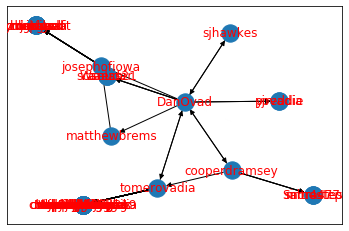

In [118]:
plotting.mpl_nx_graph(g)

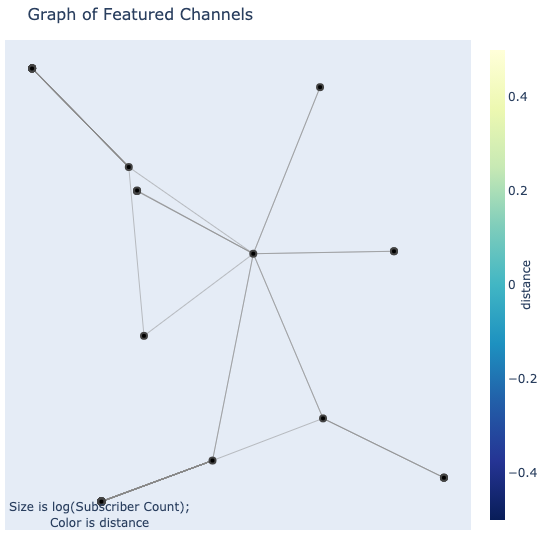

In [126]:
plotting.plotly_network_graph(G, color_setting = 'distance')

In [ ]:
## Testing to create generate_user_details_dict function

users_list = []

user_details_dict = github_request('danovad')
#user_following_list = github_request('danovad', endpoint = 'following')
user_details_dict['following'] = [user['login'] for user in github_request('danovad', endpoint = 'following')]

users_list.append(user_details_dict)

In [ ]:
features = ['login','id','type','followers','following','public_repos','bio','updated_at','created_at']